In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import gamma
from sklearn.metrics import r2_score
from emission import *
from detection import *
import cross_sections as cs
from constants import *
from tqdm import tqdm
from scipy.integrate import simps


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [83]:
E = np.linspace(1.804, 100, 1000000) # Neutrino detection energy
detector = 'super-k'
resolution = 0.05 # Fraction of error in energy reconstruction
distance = 1000 # distance in parsecs
n_target = (32000000000/18.01528)*6.022e23*2

In [84]:
samples_no = energy_sampler(E, 2e53, resolution, 'proportional', detector, 'normal', distance)
samples_io = energy_sampler(E, 2e53, resolution, 'proportional', detector, 'inverted', distance)


Number of expected neutrinos by flavor at 1000 parsecs

electron neutrinos: 150
electron antineutrinos: 3238
mu/tau (anti)neutrinos: 16

Number of expected neutrinos by flavor at 1000 parsecs

electron neutrinos: 146
electron antineutrinos: 3318
mu/tau (anti)neutrinos: 16


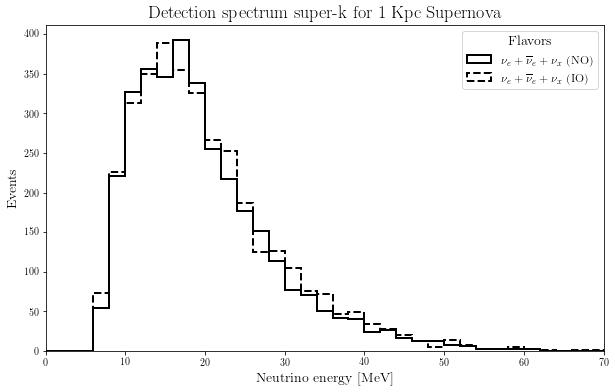

In [85]:
fig = plt.figure(figsize=(10,6))
plt.hist(samples_no['Total'], bins = [2*i for i in range(50)], histtype = 'step', color = 'black',
        lw = 2, label = r'$\nu_e + \overline{\nu}_e + \nu_x$ (NO)')
plt.hist(samples_io['Total'], bins = [2*i for i in range(50)], histtype = 'step', color = 'black',
        lw = 2, label = r'$\nu_e + \overline{\nu}_e + \nu_x$ (IO)', ls = '--')
lgd = plt.legend(title = 'Flavors', loc = 'upper right', fontsize = 12)
title = lgd.get_title()
title.set_fontsize(14)
plt.xlabel('Neutrino energy [MeV]', fontsize = 14)
plt.ylabel('Events', fontsize = 14)
plt.title(f'Detection spectrum {detector} for {int(distance/1000)} Kpc Supernova', fontsize = 18)
plt.xlim(0, 70)
# plt.savefig(f'detection_spectrum_{detector}_{int(distance/1000)}_kpc.png',
#             bbox_inches = 'tight', dpi = 300)
plt.show()

In [86]:
events_tot_no = len(samples_no['Total'])
events_tot_io = len(samples_io['Total'])

In [87]:
bins = np.array([2*(i+1) for i in range(50)])
bins_mid = (bins[:-1] + bins[1:])/2

In [88]:
height_no = []
height_io = []
for i in range(len(bins)-1):
    events_in_bin_no = len(np.where((samples_no['Total'] < bins[i+1]) & (samples_no['Total'] >= bins[i]))[0])
    height_no.append(events_in_bin_no)
    events_in_bin_io = len(np.where((samples_io['Total'] < bins[i+1]) & (samples_io['Total'] >= bins[i]))[0])
    height_io.append(events_in_bin_io)
    
height_no = np.array(height_no)
height_io = np.array(height_io)

In [89]:
height_no_norm = height_no/events_tot_no/2
height_io_norm = height_io/events_tot_io/2

In [90]:
def spectra(x, α, E_mean, E_tot):
    A = E_tot*((1+α)**(1+α))/((gamma(1+α))*E_mean**(2+α))
    f_nu = A*(x**α)*np.exp(-(α + 1)*x/E_mean)
    return f_nu

In [91]:
def detection_fit(x, alpha, E_mean, E_tot):
    cross_oxygen = cs.cross_section_nu_e_oxygen(x)
    cross_oxygen_anti = cs.cross_section_nubar_e_oxygen(x)
    cross_scatter = cs.cross_section_NC_nu_e(x, 5, g1_nu_e, g2_nu_e)
    cross_scatter_anti = cs.cross_section_NC_nu_e(x, 5, g1_barnu_e, g2_barnu_e)
    cross_scatter_x = cs.cross_section_NC_nu_e(x, 5, g1_nu_x, g2_nu_x)
    cross_scatter_anti_x = cs.cross_section_NC_nu_e(x, 5, g1_barnu_x, g2_barnu_x)
    cross_ivb = cs.cross_section_CC_nu_proton(x)
    cross_argon = cs.cross_section_nu_e_argon(x)
    cross_argon_anti = cs.cross_section_nubar_e_argon(x)
    # Number of target particles
    # Total cross section
    total_cross = cross_oxygen + cross_scatter + cross_scatter_x + cross_scatter_anti_x + cross_oxygen_anti + cross_scatter_anti + cross_ivb
    # Detector efficiency
    eff = efficiency_sigmoid(x, 1, 7, 3.5)
    # Normalization
    n_target = (32000000000/18.01528)*6.022e23*2
    distance_cm = distance*3.086e18
    A = n_target/(4 * np.pi * distance_cm**2)
    # Emission spectrum
    f_nu = spectra(x, alpha, E_mean, E_tot)
    f = A*f_nu*total_cross*eff
    return f

def detection_fit_2_params(x, alpha, E_mean):
    cross_oxygen = cs.cross_section_nu_e_oxygen(x)
    cross_oxygen_anti = cs.cross_section_nubar_e_oxygen(x)
    cross_scatter = cs.cross_section_NC_nu_e(x, 5, g1_nu_e, g2_nu_e)
    cross_scatter_anti = cs.cross_section_NC_nu_e(x, 5, g1_barnu_e, g2_barnu_e)
    cross_scatter_x = cs.cross_section_NC_nu_e(x, 5, g1_nu_x, g2_nu_x)
    cross_scatter_anti_x = cs.cross_section_NC_nu_e(x, 5, g1_barnu_x, g2_barnu_x)
    cross_ivb = cs.cross_section_CC_nu_proton(x)
    cross_argon = cs.cross_section_nu_e_argon(x)
    cross_argon_anti = cs.cross_section_nubar_e_argon(x)
    # Number of target particles
    # Total cross section
    total_cross = cross_oxygen + cross_scatter + cross_scatter_x + cross_scatter_anti_x + cross_oxygen_anti + cross_scatter_anti + cross_ivb
    # Detector efficiency
    eff = efficiency_sigmoid(x, 1, 7, 3.5)
    # Normalization
    n_target = (32000000000/18.01528)*6.022e23*2
    distance_cm = distance*3.086e18
    A = n_target/(4 * np.pi * distance_cm**2)
    # Emission spectrum
    A_spec = ((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A_spec*(x**α)*np.exp(-(α + 1)*x/E_mean)
    f = A*f_nu*total_cross*eff
    return f/simps(f, x)

In [92]:
def integrand(x, alpha, E_mean):
    cross_oxygen = cs.cross_section_nu_e_oxygen(x)
    cross_oxygen_anti = cs.cross_section_nubar_e_oxygen(x)
    cross_scatter = cs.cross_section_NC_nu_e(x, 5, g1_nu_e, g2_nu_e)
    cross_scatter_anti = cs.cross_section_NC_nu_e(x, 5, g1_barnu_e, g2_barnu_e)
    cross_scatter_x = cs.cross_section_NC_nu_e(x, 5, g1_nu_x, g2_nu_x)
    cross_scatter_anti_x = cs.cross_section_NC_nu_e(x, 5, g1_barnu_x, g2_barnu_x)
    cross_ivb = cs.cross_section_CC_nu_proton(x)
    cross_argon = cs.cross_section_nu_e_argon(x)
    cross_argon_anti = cs.cross_section_nubar_e_argon(x)
    # Number of target particles
    # Total cross section
    total_cross = cross_oxygen + cross_scatter + cross_scatter_x + cross_scatter_anti_x + cross_oxygen_anti + cross_scatter_anti + cross_ivb
    # Detector efficiency
    eff = efficiency_sigmoid(x, 1, 7, 3.5)
    # Normalization
    # distance_cm = distance*3.09e16
    # A = n_target/(4 * np.pi * distance_cm**2)
    # Emission spectrum
    # A = ((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    # f_nu = A*(x**α)*np.exp(-(α + 1)*x/E_mean)
    spectrum = spectra(x, alpha, E_mean, 1)
    f = spectrum*total_cross*eff
    return f

In [93]:
def rejABC(model, x, y, prior_params, eps, n_sample):
    # prior_params: list of ranges for uniform priors;
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(prior_params) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in tqdm(range(n_sample)):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
        
        d = np.sqrt(np.sum(((y-model(x, *p[:-1])))**2))/len(x)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
    
    return post[1:]

In [94]:
def sort(n, hist, bins): 
    # n: how many numbers to sort;
    # hist: l-sized array with height of columns of normalized histogram;
    # bins: (l+1)-sized array with values of bins divisions
    
    d = bins[1] - bins[0] # Bin size
    
    dat = [] # List of sorted random numbers
    
    for i in range(n):
        
        x = np.random.uniform(0., 1.)
        
        # Conversion of 0-1 random number to number sorted according to the given histogram
        for j in range(len(hist)):
            
            if (x < np.sum(hist[:j+1])*d):
                
                dat.append(np.random.uniform(bins[j], bins[j+1]))
                break
    
    return np.array(dat) # Converts list of sorted random numbers to numpy array

In [95]:
def smcABC(model, x, y, hist, bins, n_bins, p_std, eps, n_sample, n_max):
    # model: function to be fit; 
    # hist+bins: past posterior for new prior
    # n_bins: number of bins to be used to make new prior from last posterior
    # p_std: standard deviations of last posterior, to add noise to new posterior
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(hist) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            # p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j]/n_bins)
        
        d = np.sqrt(np.sum(((y-model(x, *p[:-1])))**2))/len(x)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
            
        if (len(post) > n_max):
            break
            
    return post[1:]

In [96]:
prior_params = np.array([[0,5],[0,20],[1e53,8e53]], dtype=np.float64)

In [97]:
eps = 50
post = rejABC(detection_fit, bins_mid, height_no, prior_params, eps, 100000)

100%|██████████| 100000/100000 [01:54<00:00, 874.60it/s]


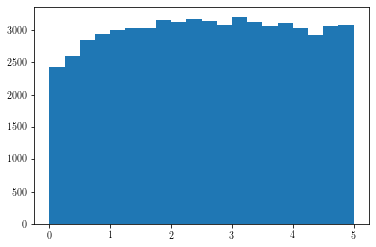

In [98]:
plt.hist(post[:,0], bins = 20)
plt.show()

In [99]:
n_bins = 30
repeat = 10
tol = [eps]

for l in tqdm(range(repeat)):
    p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
    p_std = np.std(post[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    
    hist = np.zeros((len(p), n_bins))
    bins = np.zeros((len(p), n_bins+1))
    
    # Define new priors
    for k in range(len(hist)):
        hist[k], bins[k] = np.histogram(post[:, k], n_bins, density=True)
    eps = np.median(post[:,-1])
    tol.append(eps)
    post = smcABC(detection_fit, bins_mid, height_no, hist, bins, n_bins, p_std, eps, 1000000,
                  100000)

100%|██████████| 10/10 [1:00:06<00:00, 360.70s/it]


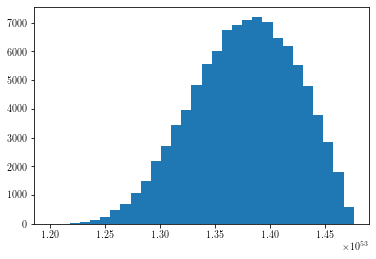

In [100]:
plt.hist(post[:,2], bins = 30)
plt.show()

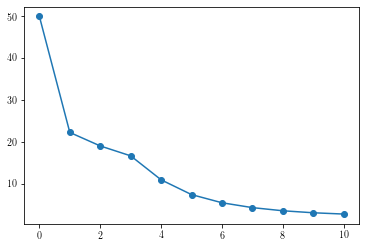

In [101]:
plt.plot(tol)
plt.scatter([i for i in range(len(tol))], tol)
# plt.yscale('log')

In [112]:
posterior = pd.DataFrame(post)
posterior = posterior.rename(columns={0: r'Pinch $\alpha$',
                                      1: r'Mean energy $\left \langle E \right \rangle$',
                                      2: r'Total luminosity $L$',
                                      3: r'Error (RMSE)'})

In [114]:
posterior.head()

,Pinch $\alpha$,Mean energy $\left \langle E \right \rangle$,Total luminosity $L$,Error (RMSE)
0,1.567273,10.945075,1.392782e+53,2.524248
1,2.070774,11.014031,1.345973e+53,2.648938
2,1.656972,11.439123,1.339543e+53,2.599372
3,1.521126,10.791473,1.313634e+53,2.770546
4,1.983551,11.476710,1.392276e+53,2.170958


<Figure size 720x576 with 0 Axes>

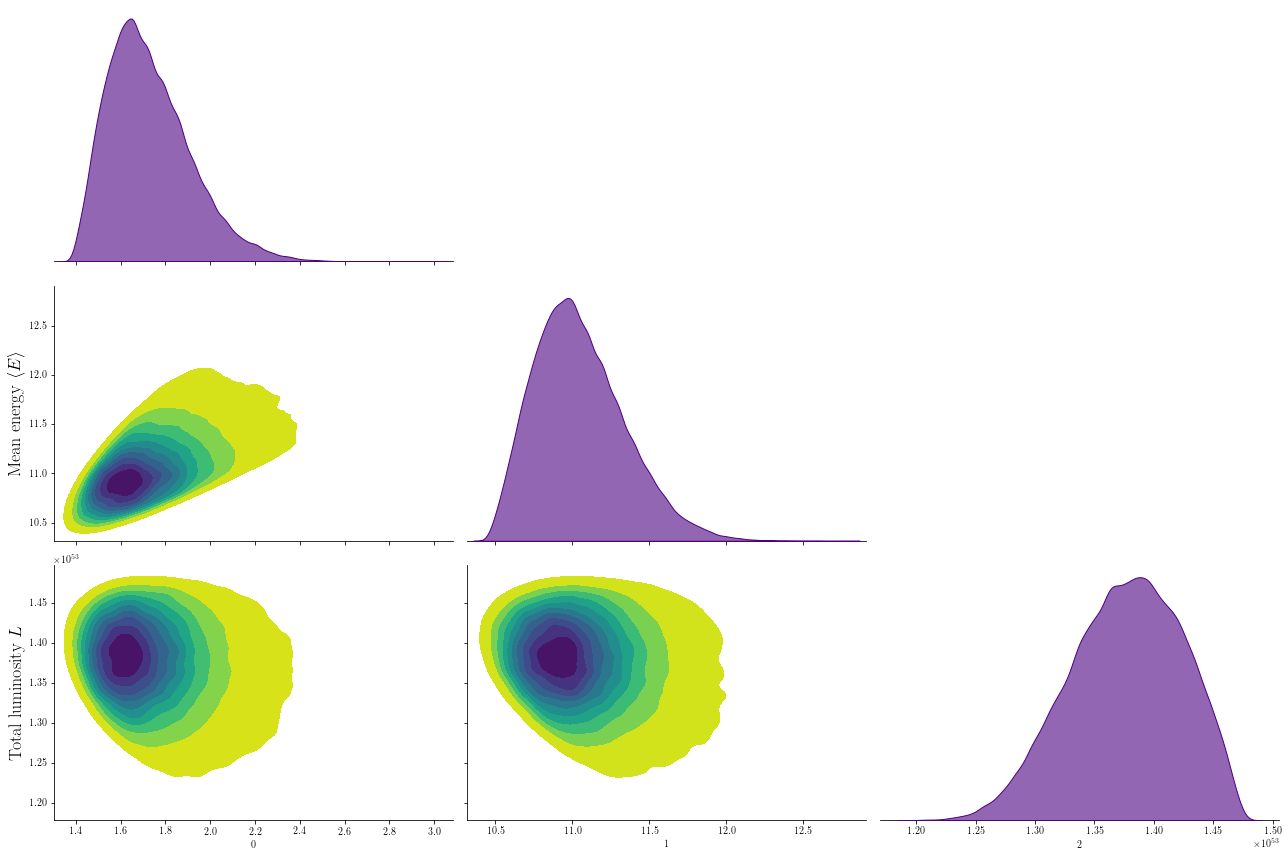

In [111]:
fig = plt.figure(figsize=(10,8))
g = sns.pairplot(data = posterior.drop(columns=['Error (RMSE)']), kind="kde", height=4, aspect=1.5,
                 plot_kws= {'cmap': 'viridis_r',
                            'levels': [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                            'fill': True},
                 diag_kws={'color': (68/255,1/255,184/255), 'alpha': 0.6,
                           'linewidth': 2},
                 corner = True)

g.map_lower(sns.kdeplot, levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], color=".2")
g.axes[1,0].set_ylabel(r'Mean energy $\left \langle E \right \rangle$', fontsize = 18)
g.axes[2,0].set_ylabel(r'Total luminosity $L$', fontsize = 18)
g.axes[2,0].set_xlabel(r'Pinch $\alpha$', fontsize = 18)
g.axes[2,1].set_xlabel(r'Mean energy $\left \langle E \right \rangle$', fontsize = 18)
# g.axes[0,0].vlines(s_max[0], 0.11825, 0.1198, linestyles = 'dashed', color = 'black')
# g.axes[0,0].text(1.001*s_max[0], 0.11980, f'MAP = {s_max[0]:.5f}', fontsize = 12, ha = 'center')
# g.axes[0,0].set_ylim(0.11825, 0.12025)
# g.axes[2,0].set_xlabel('Growth rate $\lambda$', fontsize = 18)
# g.axes[1,0].set_ylim(14.5, 15)
# g.axes[1,1].set_xlabel('Standard deviation $\sigma$', fontsize = 18)
# g.axes[1,1].text(14.9, 14.98, f'MAP: {s_max[1]:.4f}', fontsize = 12)
# g.axes[1,1].set_xlim(14.5, 15)
# g.axes[1,1].vlines(s_max[1], 14.5, 15, linestyles = 'dashed', color = 'black')

plt.tight_layout()
# fig.patch.set_alpha(0)
# for ax in fig.axes:
#     ax.patch.set_alpha(0)
# plt.savefig('pairplot.svg', dpi = 300, bbox_inches = 'tight')

In [104]:
p

array([2.60775874e+00, 1.22984887e+01, 1.26809297e+53])

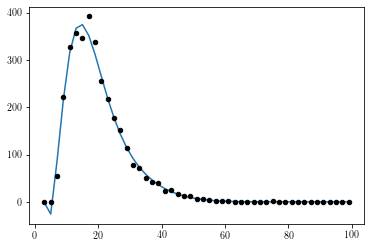

In [105]:
plt.plot(bins_mid, detection_fit(bins_mid, *p), zorder = 0)
plt.scatter(bins_mid, height_no, color = 'black', s = 20)

In [ ]:
alpha_post = post[:,0]
E_mean_post = post[:,1]
E = np.linspace(2, 100, 10000)
denominator = ((1+alpha_post)**(1+alpha_post))*n_target
distance_cm = distance*3.086e18
L = []
for i in tqdm(range(len(post[:,0]))):
    numerator = events_tot_no*(distance_cm**2)*4*np.pi*gamma(1+alpha_post[i])*(E_mean_post[i]**(2+alpha_post[i]))
    L.append(numerator/(denominator[i]*simps(integrand(E, alpha_post[i], E_mean_post[i]), E)))
    
L = np.array(L)

In [ ]:
plt.hist(L, bins = 30)
plt.show()

In [106]:
masses = np.random.normal(1.33,0.09,len(post[:,2]))
R = 10*3.6e53*((masses/1.5)**2)/post[:,2]

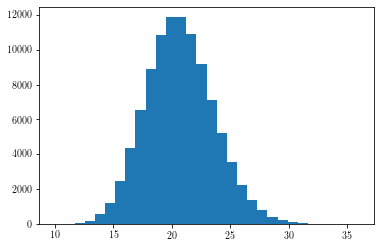

In [107]:
plt.hist(R, bins = 30)
plt.show()

<AxesSubplot:>

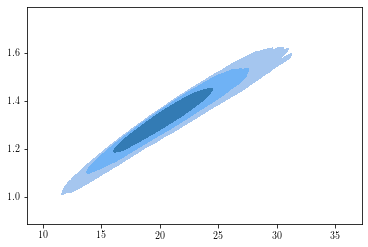

In [108]:
sns.kdeplot(R, masses, levels = [0.003, 0.05, 0.32, 1], fill = True)

In [ ]:
sns.kdeplot(R, masses, levels = [0.003, 0.05, 0.32, 1], fill = True)
plt.xlim(6, 18)
plt.ylim(0, 3)